# `causalml` - Meta-Learner Example Notebook

In [1]:
# pick the right base path (only run ONCE)
import os
base_path = os.path.abspath("../causalml")
os.chdir(base_path)
print("set dir to base_path:", base_path)

set dir to base_path: /Users/mike.yung/Documents/repos/causalml/causalml


In [2]:
%reload_ext autoreload
%autoreload 2

In [19]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost import XGBRegressor
import warnings

# from causalml.inference.meta import XGBTLearner, MLPTLearner
from inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
from inference.meta import LRSRegressor
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset import *
from causalml.metrics import *

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# imports from package
import logging
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
import statsmodels.api as sm
from copy import deepcopy

logger = logging.getLogger('causalml')
logging.basicConfig(level=logging.INFO)

%matplotlib inline

# TO DO:
- replace r2e with vague terms
- test code
- isinstance verification for e (array vs dict)

### Generate synthetic data
Note: we randomize the assignment of treatment flag across `r2e`, `r2j`, and `universal_control` AFTER the synthetic data generation process, so it doesn't make sense to measure accuracy metrics here. Next steps would be to include multi-treatment in the DGP itself.

In [20]:
# Generate synthetic data using mode 1
y, X, treatment, tau, b, e = synthetic_data(mode=1, n=10000, p=8, sigma=1.0)

treatment = np.array([('r2e' if np.random.random() > 0.2 else 'r2j') 
                      if val==1 else 'universal_control' for val in treatment])

e = {group: e for group in np.unique(treatment)}

In [21]:
y.shape, X.shape, treatment.shape, tau.shape, b.shape, e.keys()

((10000,),
 (10000, 8),
 (10000,),
 (10000,),
 (10000,),
 dict_keys(['r2e', 'r2j', 'universal_control']))

In [22]:
pd.Series(treatment).value_counts()

universal_control    4792
r2e                  4206
r2j                  1002
dtype: int64

# S-Learner

### Calculate Average Treatment Effect (ATE)
A meta-learner can be instantiated by calling a base learner class and providing an sklearn/xgboost regressor class as input. Alternatively, we have provided some ready-to-use learners that have already inherited their respective base learner class capabilities. This is more abstracted and allows these tools to be quickly and readily usable.

In [23]:
learner_s = BaseSRegressor(XGBRegressor(), control_name='universal_control')
ate_s = learner_s.estimate_ate(X=X, treatment=treatment, y=y, return_ci=False)

INFO:causalml:Error metrics for r2e
INFO:causalml:RMSE (Control): 0.988941
INFO:causalml: MAE (Control): 0.793387
INFO:causalml:RMSE (Treatment): 0.976328
INFO:causalml: MAE (Treatment): 0.781079
INFO:causalml:Error metrics for r2j
INFO:causalml:RMSE (Control): 0.998260
INFO:causalml: MAE (Control): 0.798443
INFO:causalml:RMSE (Treatment): 0.937652
INFO:causalml: MAE (Treatment): 0.757923


In [24]:
ate_s

array([0.32285869, 0.19792396])

In [25]:
learner_s._classes

{'r2e': 0, 'r2j': 1}

### Calculate Average Treatment Effect (ATE) with Confidence Intervals
Note: S-Learner is the only learner that uses bootstrapping to get confidence intervals.

In [26]:
alpha = 0.05
learner_s = BaseSRegressor(XGBRegressor(), ate_alpha=alpha, control_name='universal_control')
ate_s, ate_s_lb, ate_s_ub = learner_s.estimate_ate(X=X, treatment=treatment, y=y, return_ci=True,
                               n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:Error metrics for r2e
INFO:causalml:RMSE (Control): 0.988941
INFO:causalml: MAE (Control): 0.793387
INFO:causalml:RMSE (Treatment): 0.976328
INFO:causalml: MAE (Treatment): 0.781079
INFO:causalml:Error metrics for r2j
INFO:causalml:RMSE (Control): 0.998260
INFO:causalml: MAE (Control): 0.798443
INFO:causalml:RMSE (Treatment): 0.937652
INFO:causalml: MAE (Treatment): 0.757923
INFO:causalml:11/100 bootstraps completed. (6s lapsed)
INFO:causalml:21/100 bootstraps completed. (11s lapsed)
INFO:causalml:31/100 bootstraps completed. (17s lapsed)
INFO:causalml:41/100 bootstraps completed. (22s lapsed)
INFO:causalml:51/100 bootstraps completed. (28s lapsed)
INFO:causalml:61/100 bootstraps completed. (33s lapsed)
INFO:causalml:71/100 bootstraps completed. (39s lapsed)
INFO:causalml:81/100 bootstraps completed. (44s lapsed)
INFO:causalml:91/100 bootstraps completed. (50s lapsed)


In [55]:
np.vstack((ate_s_lb, ate_s, ate_s_ub))

array([[0.41677539, 0.24936168],
       [0.46277096, 0.31626756],
       [0.50876652, 0.38317343]])

### Calculate Conditional Average Treatment Effect (CATE)

In [34]:
learner_s = BaseSRegressor(XGBRegressor(), control_name='universal_control')
cate_s = learner_s.fit_predict(X=X, treatment=treatment, y=y, return_ci=False)

INFO:causalml:Error metrics for r2e
INFO:causalml:RMSE (Control): 0.988941
INFO:causalml: MAE (Control): 0.793387
INFO:causalml:RMSE (Treatment): 0.976328
INFO:causalml: MAE (Treatment): 0.781079
INFO:causalml:Error metrics for r2j
INFO:causalml:RMSE (Control): 0.998260
INFO:causalml: MAE (Control): 0.798443
INFO:causalml:RMSE (Treatment): 0.937652
INFO:causalml: MAE (Treatment): 0.757923


In [35]:
cate_s

array([[0.37033653, 0.13440609],
       [0.32564282, 0.09924769],
       [0.2427628 , 0.15917277],
       ...,
       [0.32736456, 0.1633774 ],
       [0.29325938, 0.00615835],
       [0.3569839 , 0.09473681]])

### Calculate Conditional Average Treatment Effect (CATE) with Confidence Intervals

In [36]:
alpha = 0.05
learner_s = BaseSRegressor(XGBRegressor(), ate_alpha=alpha, control_name='universal_control')
cate_s, cate_s_lb, cate_s_ub = learner_s.fit_predict(X=X, treatment=treatment, y=y, return_ci=True,
                               n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:Error metrics for r2e
INFO:causalml:RMSE (Control): 0.988941
INFO:causalml: MAE (Control): 0.793387
INFO:causalml:RMSE (Treatment): 0.976328
INFO:causalml: MAE (Treatment): 0.781079
INFO:causalml:Error metrics for r2j
INFO:causalml:RMSE (Control): 0.998260
INFO:causalml: MAE (Control): 0.798443
INFO:causalml:RMSE (Treatment): 0.937652
INFO:causalml: MAE (Treatment): 0.757923
INFO:causalml:11/100 bootstraps completed. (6s lapsed)
INFO:causalml:21/100 bootstraps completed. (11s lapsed)
INFO:causalml:31/100 bootstraps completed. (17s lapsed)
INFO:causalml:41/100 bootstraps completed. (23s lapsed)
INFO:causalml:51/100 bootstraps completed. (28s lapsed)
INFO:causalml:61/100 bootstraps completed. (34s lapsed)
INFO:causalml:71/100 bootstraps completed. (39s lapsed)
INFO:causalml:81/100 bootstraps completed. (45s lapsed)
INFO:causalml:91/100 bootstraps completed. (50s lapsed)


In [37]:
cate_s

array([[0.37033653, 0.13440609],
       [0.32564282, 0.09924769],
       [0.2427628 , 0.15917277],
       ...,
       [0.32736456, 0.1633774 ],
       [0.29325938, 0.00615835],
       [0.3569839 , 0.09473681]])

In [38]:
cate_s_lb

array([[ 0.16903253, -0.0817153 ],
       [ 0.14498152, -0.09743129],
       [-0.02855065, -0.10780186],
       ...,
       [ 0.15263323, -0.01066773],
       [ 0.18758904, -0.16499385],
       [ 0.18332611, -0.05347238]])

In [39]:
cate_s_ub

array([[0.59200499, 0.33903381],
       [0.55588762, 0.37639186],
       [0.46880216, 0.40275881],
       ...,
       [0.50411047, 0.29451183],
       [0.60400441, 0.23725823],
       [0.5838425 , 0.35298031]])

# T-Learner

### Calculate Average Treatment Effect (ATE) with Confidence Intervals

In [58]:
learner_t = BaseTRegressor(XGBRegressor(), control_name='universal_control')
ate_t, ate_t_lb, ate_t_ub = learner_t.estimate_ate(X=X, treatment=treatment, y=y)

INFO:causalml:Error metrics for r2e
INFO:causalml:RMSE (Control): 0.973033
INFO:causalml: MAE (Control): 0.781256
INFO:causalml:RMSE (Treatment): 0.938649
INFO:causalml: MAE (Treatment): 0.751823
INFO:causalml:Error metrics for r2j
INFO:causalml:RMSE (Control): 0.992381
INFO:causalml: MAE (Control): 0.793648
INFO:causalml:RMSE (Treatment): 0.768362
INFO:causalml: MAE (Treatment): 0.611264


In [60]:
np.vstack((ate_t_lb, ate_t, ate_t_ub))

array([[0.30467597, 0.22723333],
       [0.34288039, 0.27951737],
       [0.38108481, 0.3318014 ]])

### Calculate Conditional Average Treatment Effect (ATE)

In [42]:
learner_t = BaseTRegressor(XGBRegressor(), control_name='universal_control')
cate_t = learner_t.fit_predict(X=X, treatment=treatment, y=y)

INFO:causalml:Error metrics for r2e
INFO:causalml:RMSE (Control): 0.973033
INFO:causalml: MAE (Control): 0.781256
INFO:causalml:RMSE (Treatment): 0.938649
INFO:causalml: MAE (Treatment): 0.751823
INFO:causalml:Error metrics for r2j
INFO:causalml:RMSE (Control): 0.992381
INFO:causalml: MAE (Control): 0.793648
INFO:causalml:RMSE (Treatment): 0.768362
INFO:causalml: MAE (Treatment): 0.611264


In [43]:
cate_t

array([[ 0.27777576, -0.0025537 ],
       [ 0.43208611, -0.20154428],
       [ 0.14786184,  0.21264517],
       ...,
       [ 0.4014715 , -0.13369215],
       [ 0.68604362,  0.02513599],
       [ 0.67860246, -0.32197523]])

### Calculate Conditional Average Treatment Effect (ATE) with Confidence Intervals

In [44]:
learner_t = BaseTRegressor(XGBRegressor(), control_name='universal_control')
cate_t, cate_t_lb, cate_t_ub = learner_t.fit_predict(X=X, treatment=treatment, y=y, return_ci=True, n_bootstraps=100,
                                                    bootstrap_size=5000)

INFO:causalml:Error metrics for r2e
INFO:causalml:RMSE (Control): 0.973033
INFO:causalml: MAE (Control): 0.781256
INFO:causalml:RMSE (Treatment): 0.938649
INFO:causalml: MAE (Treatment): 0.751823
INFO:causalml:Error metrics for r2j
INFO:causalml:RMSE (Control): 0.992381
INFO:causalml: MAE (Control): 0.793648
INFO:causalml:RMSE (Treatment): 0.768362
INFO:causalml: MAE (Treatment): 0.611264
INFO:causalml:10/100 bootstraps completed. (6s lapsed)
INFO:causalml:20/100 bootstraps completed. (11s lapsed)
INFO:causalml:30/100 bootstraps completed. (17s lapsed)
INFO:causalml:40/100 bootstraps completed. (23s lapsed)
INFO:causalml:50/100 bootstraps completed. (28s lapsed)
INFO:causalml:60/100 bootstraps completed. (34s lapsed)
INFO:causalml:70/100 bootstraps completed. (40s lapsed)
INFO:causalml:80/100 bootstraps completed. (45s lapsed)
INFO:causalml:90/100 bootstraps completed. (51s lapsed)


In [45]:
cate_t

array([[ 0.27777576, -0.0025537 ],
       [ 0.43208611, -0.20154428],
       [ 0.14786184,  0.21264517],
       ...,
       [ 0.4014715 , -0.13369215],
       [ 0.68604362,  0.02513599],
       [ 0.67860246, -0.32197523]])

In [46]:
cate_t_lb

array([[-0.22201658, -0.69963114],
       [-0.23848298, -0.96522925],
       [-0.4593563 , -0.36840751],
       ...,
       [ 0.12090419, -0.47052266],
       [-0.42977596, -0.99949225],
       [ 0.20469286, -0.92965147]])

In [47]:
cate_t_ub

array([[1.13054974, 0.62586471],
       [1.12672175, 0.68304824],
       [1.28894761, 1.25686054],
       ...,
       [0.73597165, 0.43932298],
       [1.06732534, 0.7830918 ],
       [1.35791065, 0.60335202]])

# X-Learner

### Calculate Average Treatment Effect (ATE) with Confidence Intervals

In [80]:
learner_x = BaseXRegressor(XGBRegressor(), control_name='universal_control')
ate_x, ate_x_lb, ate_x_ub = learner_x.estimate_ate(X=X, p=e, treatment=treatment, y=y)

In [81]:
np.vstack((ate_x_lb, ate_x, ate_x_ub))

array([[0.29226742, 0.22782826],
       [0.33027346, 0.27986794],
       [0.36827951, 0.33190761]])

### Calculate Condtional Average Treatment Effect (ATE) 

In [61]:
learner_x = BaseXRegressor(XGBRegressor(), control_name='universal_control')
cate_x = learner_x.fit_predict(X=X, p=e, treatment=treatment, y=y)

In [62]:
cate_x

array([[ 0.36650637, -0.12216383],
       [ 0.40333039,  0.01863524],
       [ 0.52379155,  0.2945742 ],
       ...,
       [ 0.3604455 , -0.12414569],
       [ 0.33226529, -0.28476495],
       [ 0.22890523, -0.00719666]])

### Calculate Condtional Average Treatment Effect (ATE) with Confidence Intervals

In [63]:
learner_x = BaseXRegressor(XGBRegressor(), control_name='universal_control')
cate_x, cate_x_lb, cate_x_ub = learner_x.fit_predict(X=X, p=e, treatment=treatment, y=y, return_ci=True,
                                                     n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:10/100 bootstraps completed. (11s lapsed)
INFO:causalml:20/100 bootstraps completed. (22s lapsed)
INFO:causalml:30/100 bootstraps completed. (32s lapsed)
INFO:causalml:40/100 bootstraps completed. (42s lapsed)
INFO:causalml:50/100 bootstraps completed. (53s lapsed)
INFO:causalml:60/100 bootstraps completed. (63s lapsed)
INFO:causalml:70/100 bootstraps completed. (74s lapsed)
INFO:causalml:80/100 bootstraps completed. (85s lapsed)
INFO:causalml:90/100 bootstraps completed. (96s lapsed)


In [64]:
learner_x._classes

{'r2e': 0, 'r2j': 1}

In [65]:
cate_x

array([[ 0.36650637, -0.12216383],
       [ 0.40333039,  0.01863524],
       [ 0.52379155,  0.2945742 ],
       ...,
       [ 0.3604455 , -0.12414569],
       [ 0.33226529, -0.28476495],
       [ 0.22890523, -0.00719666]])

In [66]:
cate_x_lb

array([[-0.20076865, -0.43604701],
       [-0.07776893, -1.06379047],
       [-0.04851962, -0.15368102],
       ...,
       [ 0.17486212, -0.24250639],
       [-0.06702488, -0.78176423],
       [-0.27846991, -0.71353383]])

In [67]:
cate_x_ub

array([[0.74844774, 0.44571568],
       [0.92017255, 0.51834216],
       [0.81848718, 0.96341439],
       ...,
       [0.5959333 , 0.24373442],
       [0.76051654, 0.30073609],
       [0.73132552, 0.27787276]])

# R-Learner

### Calculate Average Treatment Effect (ATE) with Confidence Intervals

In [82]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='universal_control')
ate_r, ate_r_lb, ate_r_ub = learner_r.estimate_ate(X=X, p=e, treatment=treatment, y=y)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for r2e with R-loss
INFO:causalml:training the treatment effect model for r2j with R-loss


In [83]:
np.vstack((ate_r_lb, ate_r, ate_r_ub))

array([[0.26321572, 0.10800292],
       [0.26362685, 0.10865883],
       [0.26403798, 0.10931475]])

### Calculate Conditional Average Treatment Effect (CATE)

In [84]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='universal_control')
cate_r = learner_r.fit_predict(X=X, p=e, treatment=treatment, y=y)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for r2e with R-loss
INFO:causalml:training the treatment effect model for r2j with R-loss


### Calculate Condtional Average Treatment Effect (ATE) with Confidence Intervals

In [95]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='universal_control')
cate_r, cate_r_lb, cate_r_ub = learner_r.fit_predict(X=X, p=e, treatment=treatment, y=y, return_ci=True,
                                                     n_bootstraps=100, bootstrap_size=3000)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for r2e with R-loss
INFO:causalml:training the treatment effect model for r2j with R-loss
INFO:causalml:10/100 bootstraps completed. (10s lapsed)
INFO:causalml:20/100 bootstraps completed. (19s lapsed)
INFO:causalml:30/100 bootstraps completed. (28s lapsed)
INFO:causalml:40/100 bootstraps completed. (37s lapsed)
INFO:causalml:50/100 bootstraps completed. (46s lapsed)
INFO:causalml:60/100 bootstraps completed. (55s lapsed)
INFO:causalml:70/100 bootstraps completed. (64s lapsed)
INFO:causalml:80/100 bootstraps completed. (72s lapsed)
INFO:causalml:90/100 bootstraps completed. (82s lapsed)


In [96]:
cate_r

array([[ 0.31275874, -0.04896599],
       [ 0.32795316,  0.11169842],
       [ 0.19722641,  0.12030035],
       ...,
       [ 0.26378715, -0.06084013],
       [-0.0328095 , -0.05429262],
       [ 0.41110483, -0.0762921 ]])

In [97]:
cate_r_lb

array([[-0.45090959, -0.57718222],
       [-0.42285973, -0.59342855],
       [-0.68406428, -0.42502841],
       ...,
       [-0.06616784, -0.28936204],
       [-0.76433859, -1.06219046],
       [-0.62117668, -0.74499337]])

In [98]:
cate_r_ub

array([[0.9371004 , 0.33132645],
       [1.30804473, 0.70526177],
       [1.18989689, 0.87876232],
       ...,
       [0.77938618, 0.13846633],
       [0.99240078, 0.29567263],
       [1.14223521, 0.38470038]])

# Visualize

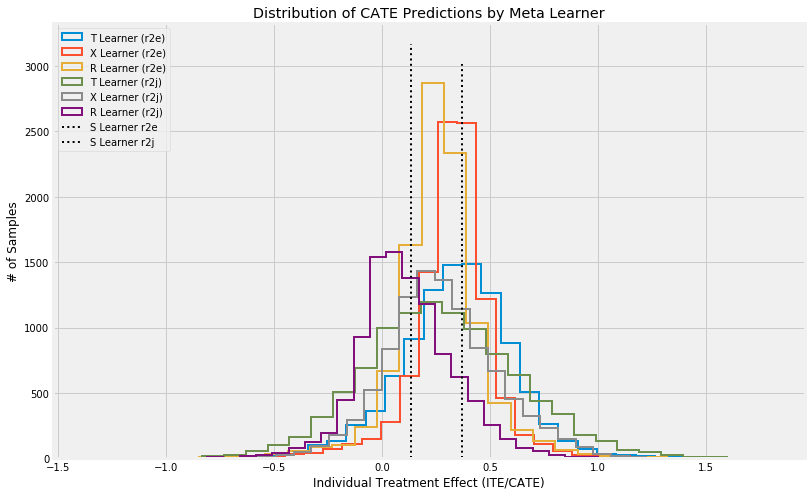

In [114]:
alpha = 1
linewidth = 2
bins = 30
plt.figure(figsize=(12,8))
for group,idx in sorted(groups.items(), key=lambda x: x[1]):
    plt.hist(cate_t[:,idx], alpha=alpha, bins=bins, label='T Learner ({})'.format(group),
             histtype='step', linewidth=linewidth)
    plt.hist(cate_x[:,idx], alpha=alpha, bins=bins, label='X Learner ({})'.format(group),
             histtype='step', linewidth=linewidth)
    plt.hist(cate_r[:,idx], alpha=alpha, bins=bins, label='R Learner ({})'.format(group),
             histtype='step', linewidth=linewidth)
    plt.vlines(cate_s[0,idx], 0, plt.axes().get_ylim()[1], label='S Learner {}'.format(group),
               linestyles='dotted', linewidth=linewidth)
plt.title('Distribution of CATE Predictions by Meta Learner')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
_=plt.legend()